In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-22T05:46:09.913841+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import time
notebookstart= time.time()

In [4]:
import os
import pickle as pkl
#import tqdm

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
import lightgbm as lgb

from itertools import product
from typing import Tuple

In [5]:
from tqdm.auto import tqdm
tqdm.pandas()

In [6]:
#from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

#print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

sklearn_version: 0.24.2


In [7]:
%watermark --iversions

numpy   : 1.20.3
lightgbm: 3.3.2
sklearn : 0.24.2
pandas  : 0.25.3



## Reproducibility block

In [8]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [9]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [10]:
NTRY = 32
NAME = f'{NTRY}_lgb_pca64_sber_bord_nose_iter_2mod'

In [11]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [12]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)

In [13]:
df_train.shape, df_test.shape,

((6981, 571), (3000, 569))

In [14]:
df_train['category'] = df_train['category'].astype('category')
df_test['category']  = df_test['category'].astype('category')

In [15]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr', 'interview']
['hour', 'dow', 'day', 'mounth', 'hour_peak', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [16]:
#num_cols.extend(['hour', 'mounth'])
cat_cols.extend([# 'hour', 'mounth', 'day', 
                 'dow', 'hour_peak',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr', 'interview',
                 'holiday', 'day_before_holiday', 'day_after_holiday', #'distrib_brdr',
                 #'spec_event_1',
                ])

In [17]:
len(num_cols)

539

In [18]:
def r2(preds: np.ndarray, data: lgb.Dataset) -> Tuple[str, float, bool]:
    label = data.get_label()
    #weight = data.get_weight()
    #p_dash = (1 - label) + (2 * label - 1) * preds
    #loss_by_example = - np.log(p_dash)
    #loss = np.average(loss_by_example, weights=weight)

    # # eval_name, eval_result, is_higher_better
    return 'r2', r2_score(preds, label), True

In [19]:
def train_lgb_cat(inp_df, inp_vals, inp_category, inp_cat_cols, inp_num_cols):

    
    num_of_leaves_vars    = [4, 8, 16, 32, 64, 128]
    max_depth_vars        = [4, 8, 16, 32]#, 64, 128]
    min_data_in_leaf_vars = [4, 8, 16, 32]#, 64, 128]
    learn_rate_vars       = [0.1, 0.05, 0.01] #1, 0.5, 
    
    min_rmse = 1000000
    ret_progress = []
    
    for nl, lr, md, mdlf in tqdm(product(num_of_leaves_vars, learn_rate_vars, max_depth_vars, min_data_in_leaf_vars), 
                                total = len(num_of_leaves_vars)*len(learn_rate_vars)*len(max_depth_vars)*len(min_data_in_leaf_vars)
                                ):
    
        params = {
            'task': 'train', 
            'boosting': 'gbdt',
            'objective': 'regression',
            'num_leaves': nl,
            'learning_rate': lr,
            'max_depth': md,
            'min_data_in_leaf': mdlf,
            'metric': {'rmse'},
            #'verbose': -1,
            'random_seed': LGB_RANDOMSEED,
            'force_col_wise': False,
            'n_jobs' : -1,
            
            
            #'reg_alpha': 10,   # != 0  Hard L1 regularization
            #'reg_lambda': 0,   # != 0  Hard L2 regularization
        }


        train_ds_views = lgb.Dataset(inp_df[inp_df.category == inp_category][cat_cols + num_cols],
                                     #inp_df[cat_cols + num_cols],
                                     inp_vals[inp_df.category == inp_category][['views']],
                                     #feature_name = [cat_cols + num_cols]
                                    )

        results = lgb.cv(params, 
                         train_ds_views, 
                         num_boost_round = 10000,
                         nfold = 5,
                         verbose_eval = 500,
                         early_stopping_rounds = 100,
                         stratified = False,
                         #return_cvbooster = True,
                        )

        optimal_rounds = np.argmin(results['rmse-mean'])
        best_cv_score  = min(results['rmse-mean'])

        if best_cv_score < min_rmse:
            ret_progress.append(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')
        
        #print(nl, lr, md, mdlf, optimal_rounds, best_cv_score)
        print(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')  
    
    return ret_progress

In [20]:
df_train[df_train.distrib_brdr == 1].shape, df_train[df_train.distrib_brdr == 0].shape

((3176, 571), (3805, 571))

In [21]:
df_test[df_test.distrib_brdr == 1].shape, df_test[df_test.distrib_brdr == 0].shape

((1413, 569), (1587, 569))

In [22]:
#views
train_views_start = lgb.Dataset(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 1][['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
train_views_end = lgb.Dataset(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 0][['views']],
                             #feature_name = [cat_cols + num_cols]
                            )

#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


#depth
train_depth_start = lgb.Dataset(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 1][['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )
train_depth_end = lgb.Dataset(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 0][['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )

#full_reads_percent
train_frp_start = lgb.Dataset(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 1][['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )
train_frp_end = lgb.Dataset(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 0][['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )

## views

In [23]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 6,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [24]:
def get_model(inp_ds, inp_params):
    
    score = lgb.cv(inp_params, 
                 inp_ds, 
                 #num_boost_round = 10000,
                 num_boost_round=600,
                 nfold = 5,
                 verbose_eval = 500,
                 #early_stopping_rounds = 100,
                 stratified = False,
                 eval_train_metric = r2,
                 feval = r2,
                 #return_cvbooster = True,
                )
    print(np.argmin(score['valid rmse-mean']), score['train rmse-mean'][np.argmin(score['valid rmse-mean'])], score['train rmse-stdv'][np.argmin(score['valid rmse-mean'])], )
    print(np.argmin(score['valid rmse-mean']), score['valid rmse-mean'][np.argmin(score['valid rmse-mean'])], score['valid rmse-stdv'][np.argmin(score['valid rmse-mean'])], )

    print(np.argmax(score['valid r2-mean']), score['train r2-mean'][np.argmax(score['valid r2-mean'])], score['train r2-stdv'][np.argmax(score['valid r2-mean'])], )
    print(np.argmax(score['valid r2-mean']), score['valid r2-mean'][np.argmax(score['valid r2-mean'])], score['valid r2-stdv'][np.argmax(score['valid r2-mean'])], )
    
    
    niters = np.argmin(score['valid rmse-mean'])
    print(niters)
    
    lgb_model = lgb.train(inp_params,
                            train_set = inp_ds,
                            num_boost_round = niters,
                            #early_stopping_rounds=30,
                            verbose_eval = False,
                           )
    
    
    return lgb_model

In [25]:
#score_v.keys()

In [26]:
#if np.argmin(score_v['valid rmse-mean']) != np.argmax(score_v['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_v['valid rmse-mean']), np.argmax(score_v['valid r2-mean']))

In [27]:
%%time
lgb_model_views_start = get_model(train_views_start, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 7726.42 + 2760.03	cv_agg's train r2: 0.989997 + 0.00471995	cv_agg's valid rmse: 60175.8 + 20602.4	cv_agg's valid r2: -0.482021 + 1.38641
158 22658.722567843 6764.297546266307
158 59732.90861578846 20449.791919867737
598 0.9944082090457252 0.002642600275094163
598 -0.47603387883499926 1.3882707515402497
158


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 36.5 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

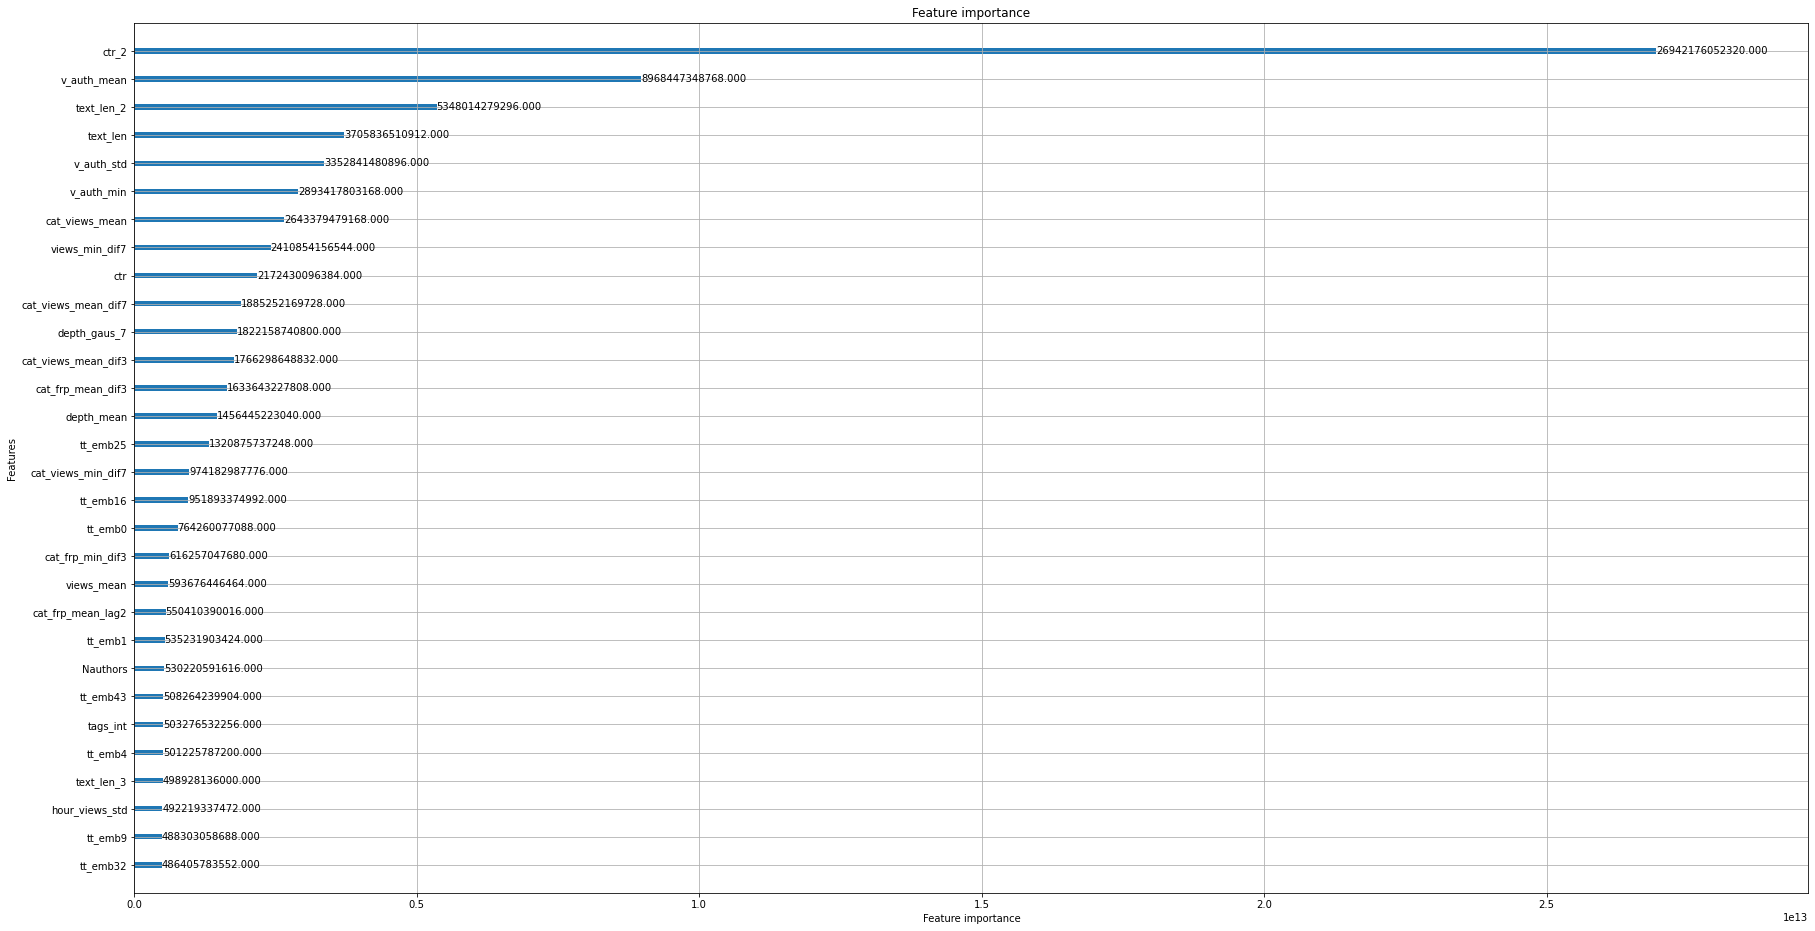

In [28]:
lgb.plot_importance(lgb_model_views_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'split')
# importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; 
# “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

In [29]:
%%time
lgb_model_views_end = get_model(train_views_end, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 696.004 + 142.066	cv_agg's train r2: 0.997662 + 0.000797972	cv_agg's valid rmse: 9912.49 + 944.416	cv_agg's valid r2: 0.204815 + 0.159659
121 2757.1142765800296 217.98510382195505
121 9884.099774739654 938.3504540374701
595 0.9985447326241015 0.000513685247659351
595 0.20543708989450274 0.1600218545673605
121


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 39.6 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

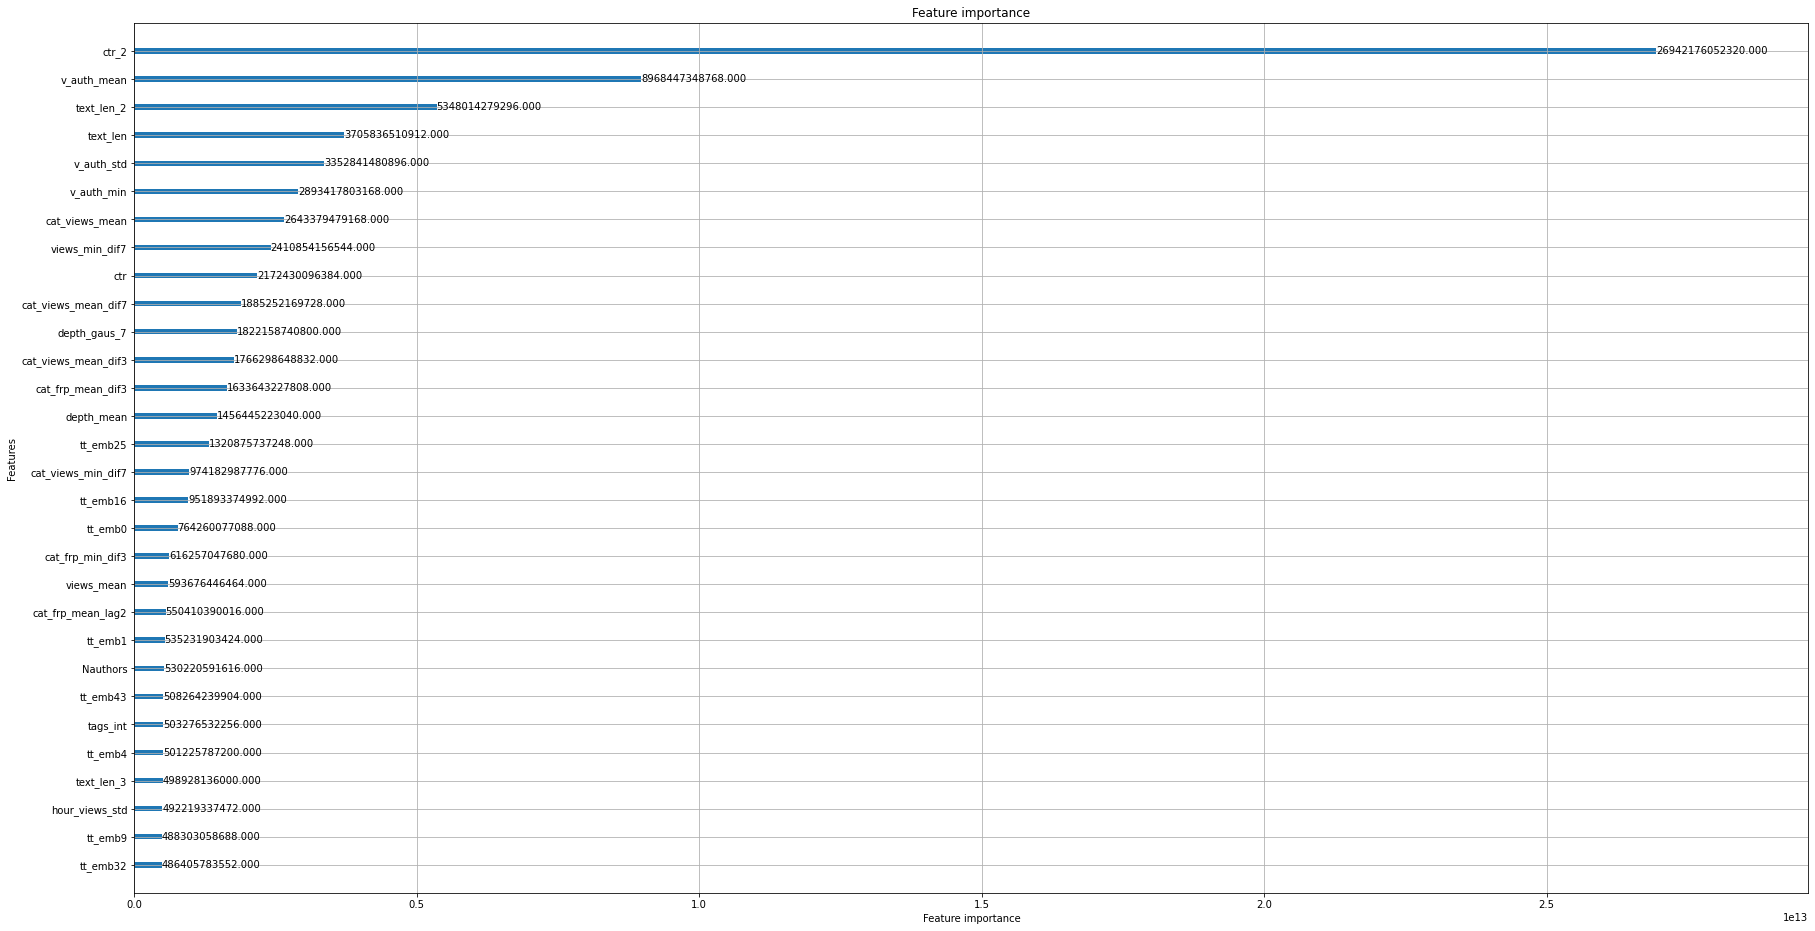

In [30]:
lgb.plot_importance(lgb_model_views_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')

## depth

In [31]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [32]:
#if np.argmin(score_d['valid rmse-mean']) != np.argmax(score_d['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_d['valid rmse-mean']), np.argmax(score_d['valid r2-mean']))

In [33]:
%%time
lgb_model_depth_start = get_model(train_depth_start, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.001527 + 0.000521671	cv_agg's train r2: 0.999068 + 0.000483346	cv_agg's valid rmse: 0.0363328 + 0.00310894	cv_agg's valid r2: 0.183598 + 0.205615
72 0.015284127060253571 0.00041551799830996525
72 0.03594899224755908 0.0031036133486372665
597 0.9994906179437655 0.00028268508926436854
597 0.1837848203652492 0.20415093916989513
72


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 35.1 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

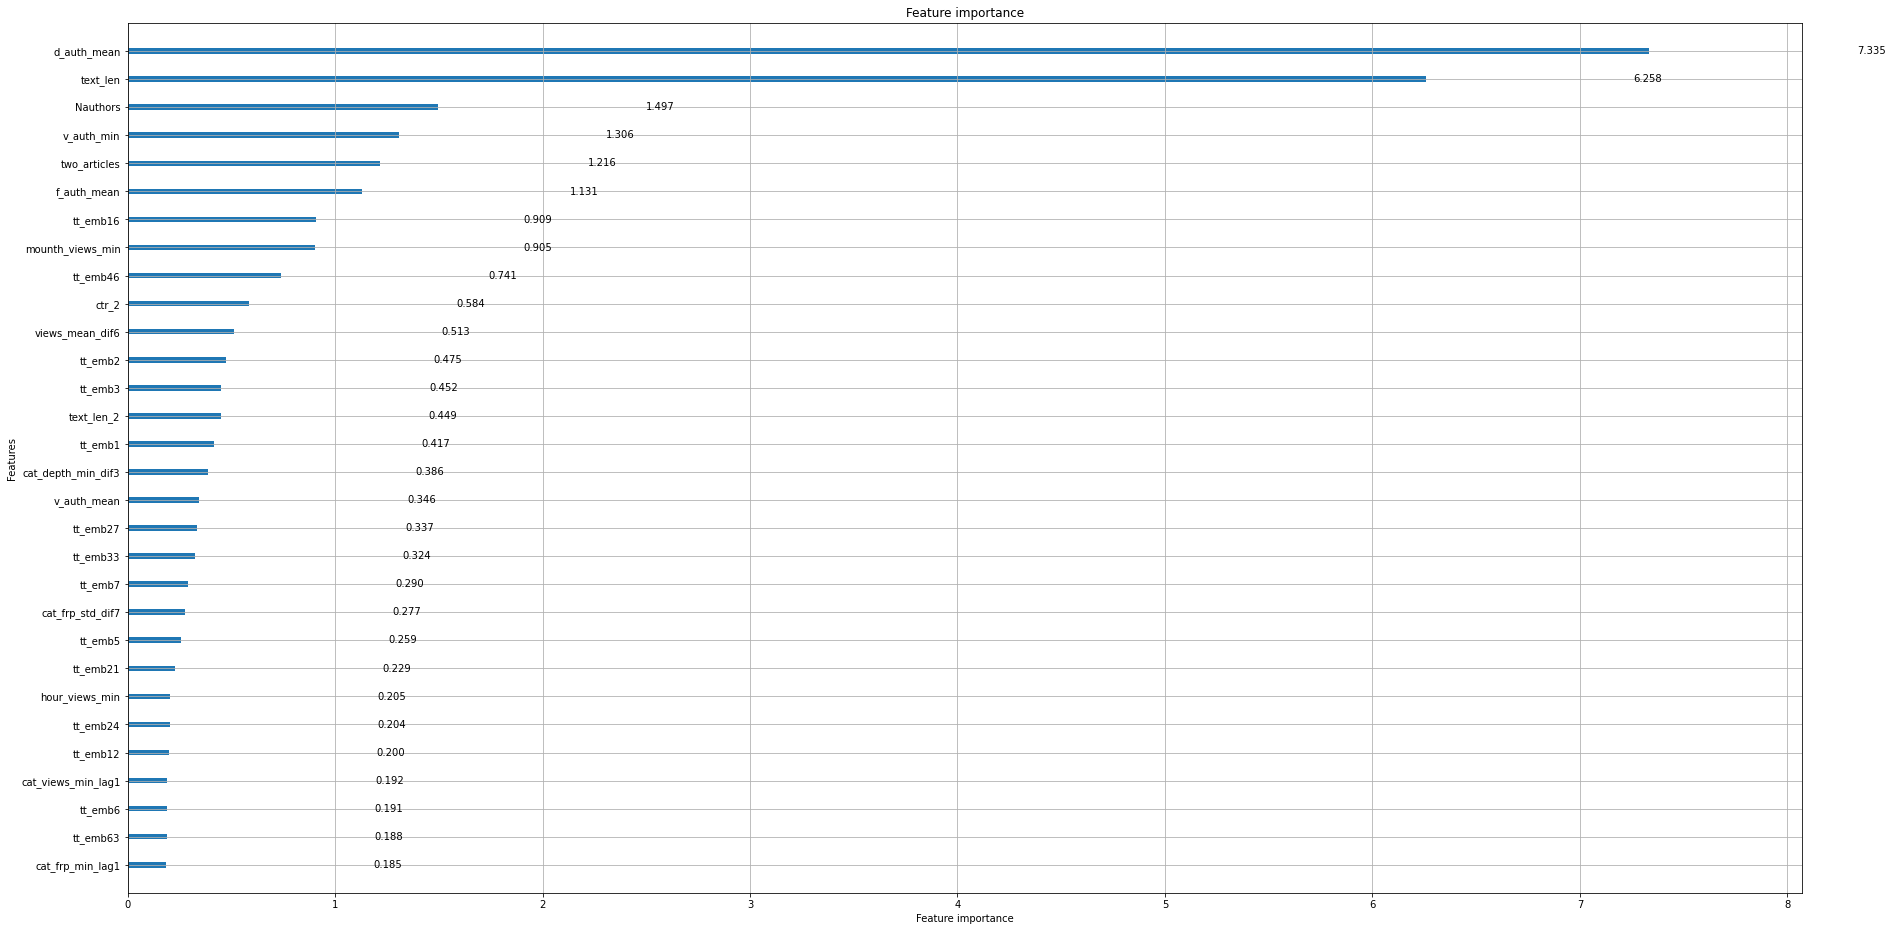

In [34]:
lgb.plot_importance(lgb_model_depth_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

In [35]:
%%time
lgb_model_depth_end = get_model(train_depth_end, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.00228199 + 0.000581432	cv_agg's train r2: 0.987143 + 0.00514073	cv_agg's valid rmse: 0.0164694 + 0.00224171	cv_agg's valid r2: -0.345129 + 0.174115
55 0.010400699004784304 0.0009457055588562005
55 0.016124633054726757 0.0021896420473533915
159 0.879224449821443 0.035206320046322306
159 -0.33854590994402645 0.17960914475272638
55


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 38.4 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

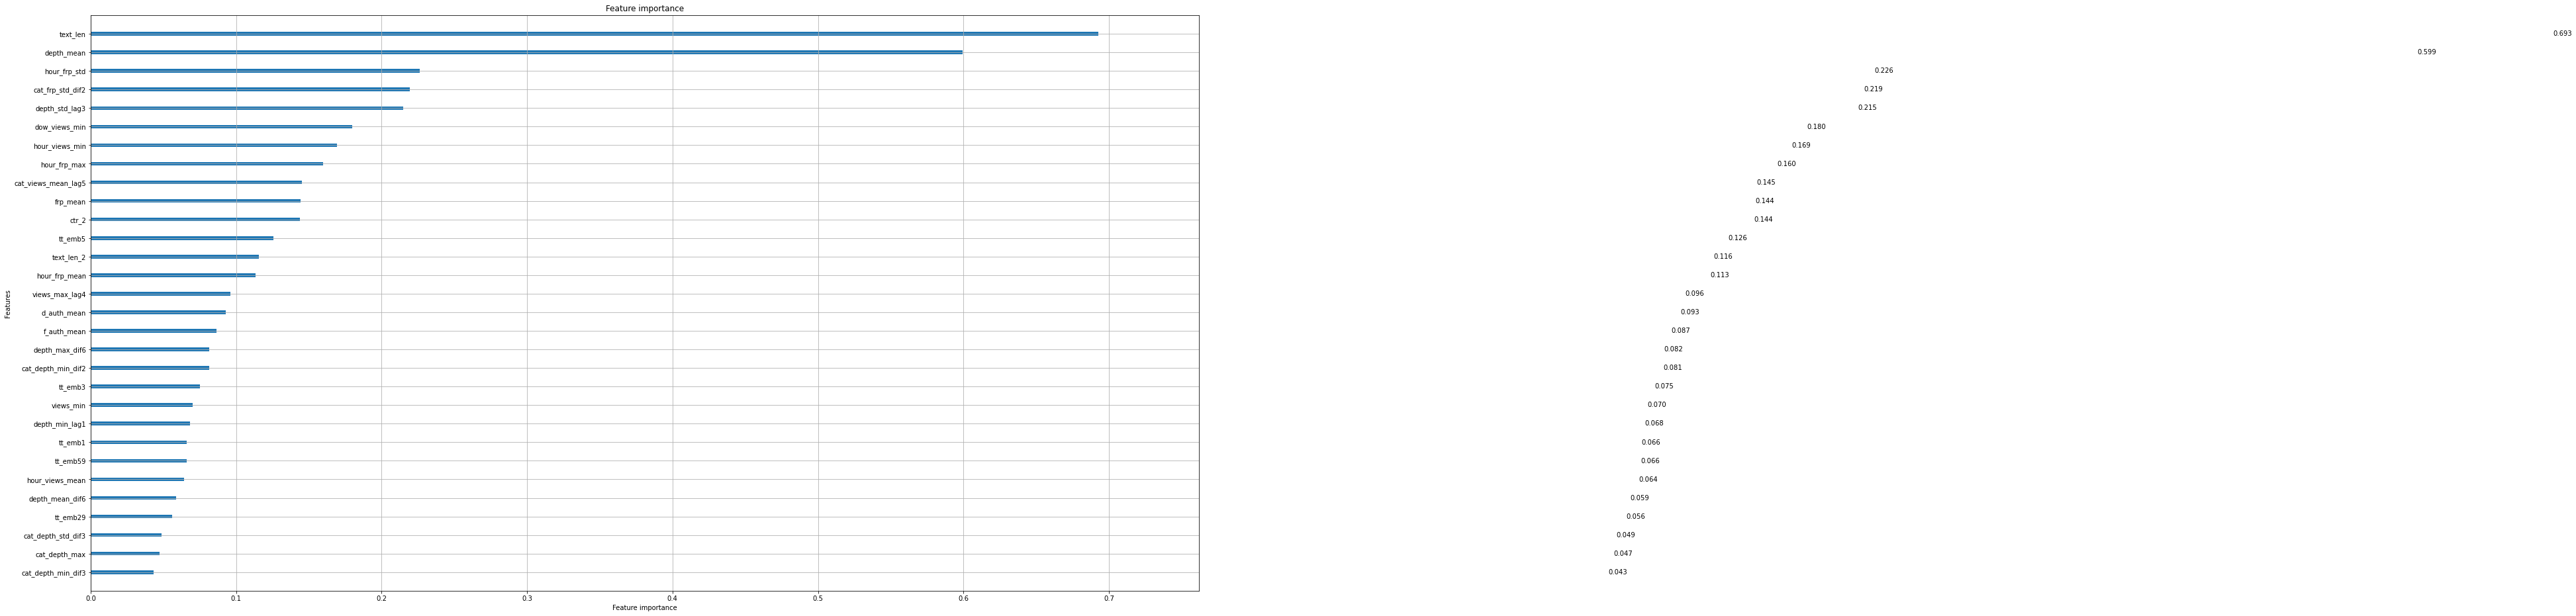

In [36]:
lgb.plot_importance(lgb_model_depth_end, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

## full_reads_percent

In [37]:
#if np.argmin(score_f['valid rmse-mean']) != np.argmax(score_f['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_f['valid rmse-mean']), np.argmax(score_f['valid r2-mean']))

In [38]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [39]:
%%time
lgb_model_frp_start = get_model(train_frp_start, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.0958107 + 0.00372271	cv_agg's train r2: 0.999917 + 6.02174e-06	cv_agg's valid rmse: 7.11056 + 0.10789	cv_agg's valid r2: 0.203386 + 0.0663394
178 1.1994846332519584 0.01565318925012165
178 7.0920085827780825 0.10858318559489707
544 0.9999549664230024 5.293588676929968e-06
544 0.20349298432212565 0.06649384896704585
178


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 33.5 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

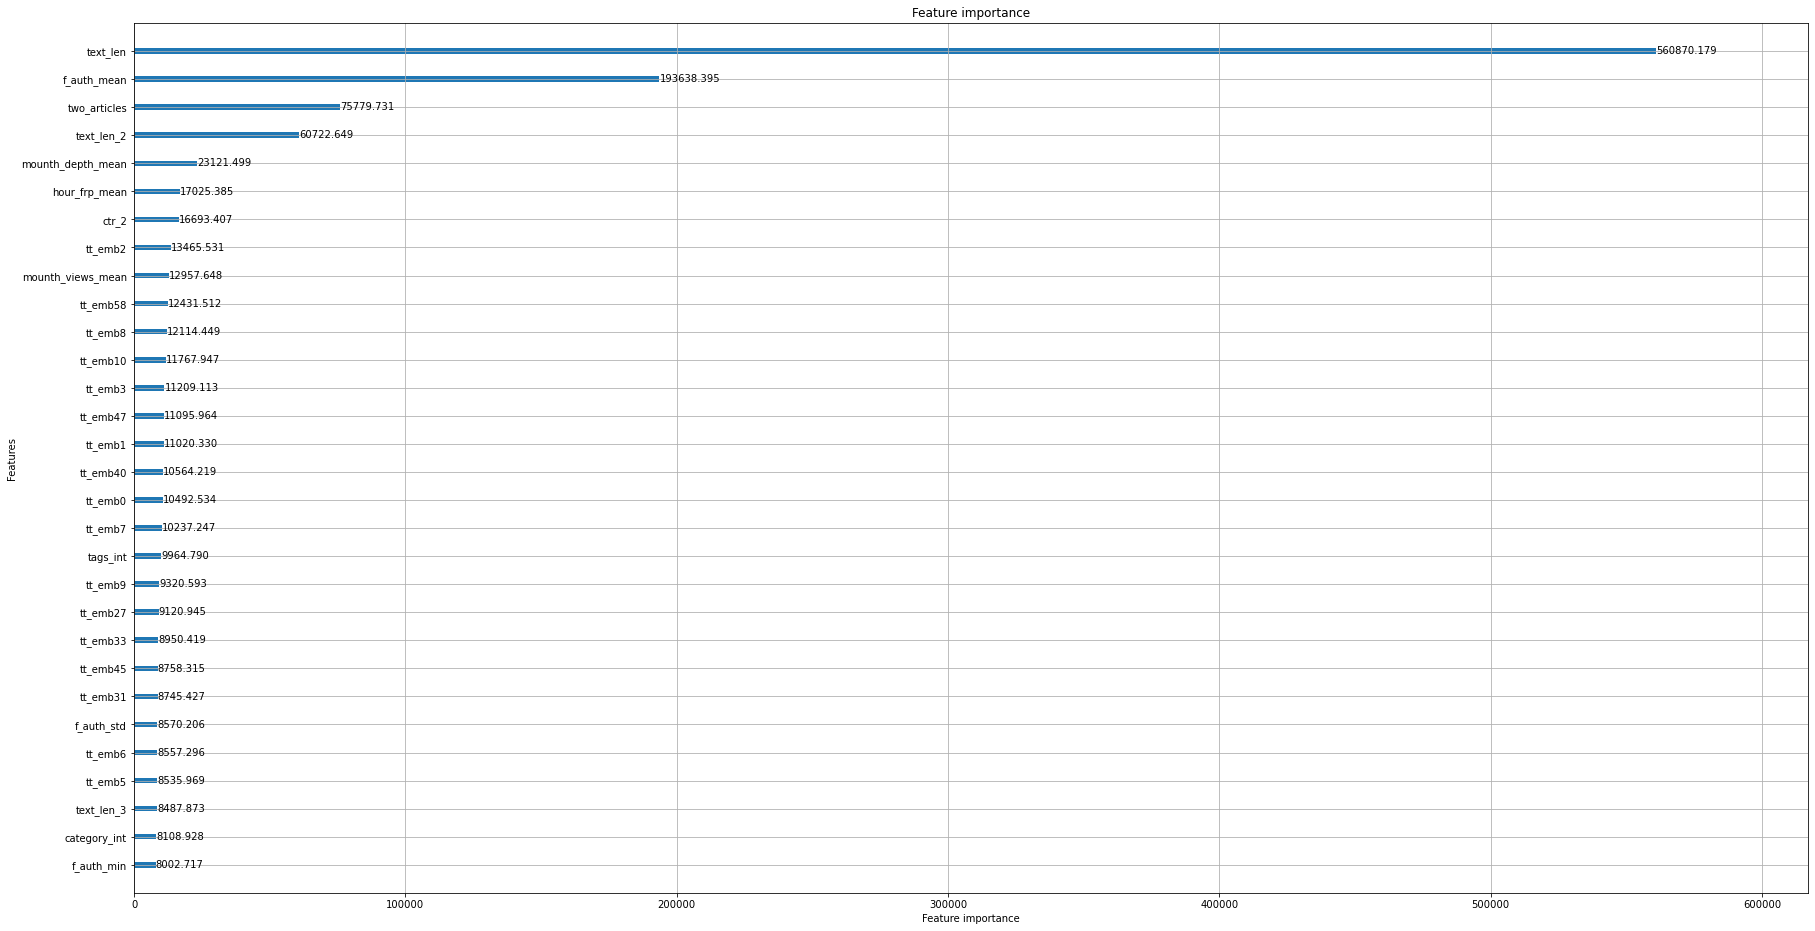

In [40]:
lgb.plot_importance(lgb_model_frp_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

In [41]:
%%time
lgb_model_frp_end = get_model(train_frp_end, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.191901 + 0.0125391	cv_agg's train r2: 0.999598 + 5.24386e-05	cv_agg's valid rmse: 6.56764 + 0.153248	cv_agg's valid r2: 0.203516 + 0.035992
77 3.125004654887553 0.02206594961732132
77 6.538912235458336 0.15803307952732798
589 0.9998217989208685 3.6938363249448266e-05
589 0.2039823792502205 0.03632507694549519
77


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 50.7 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

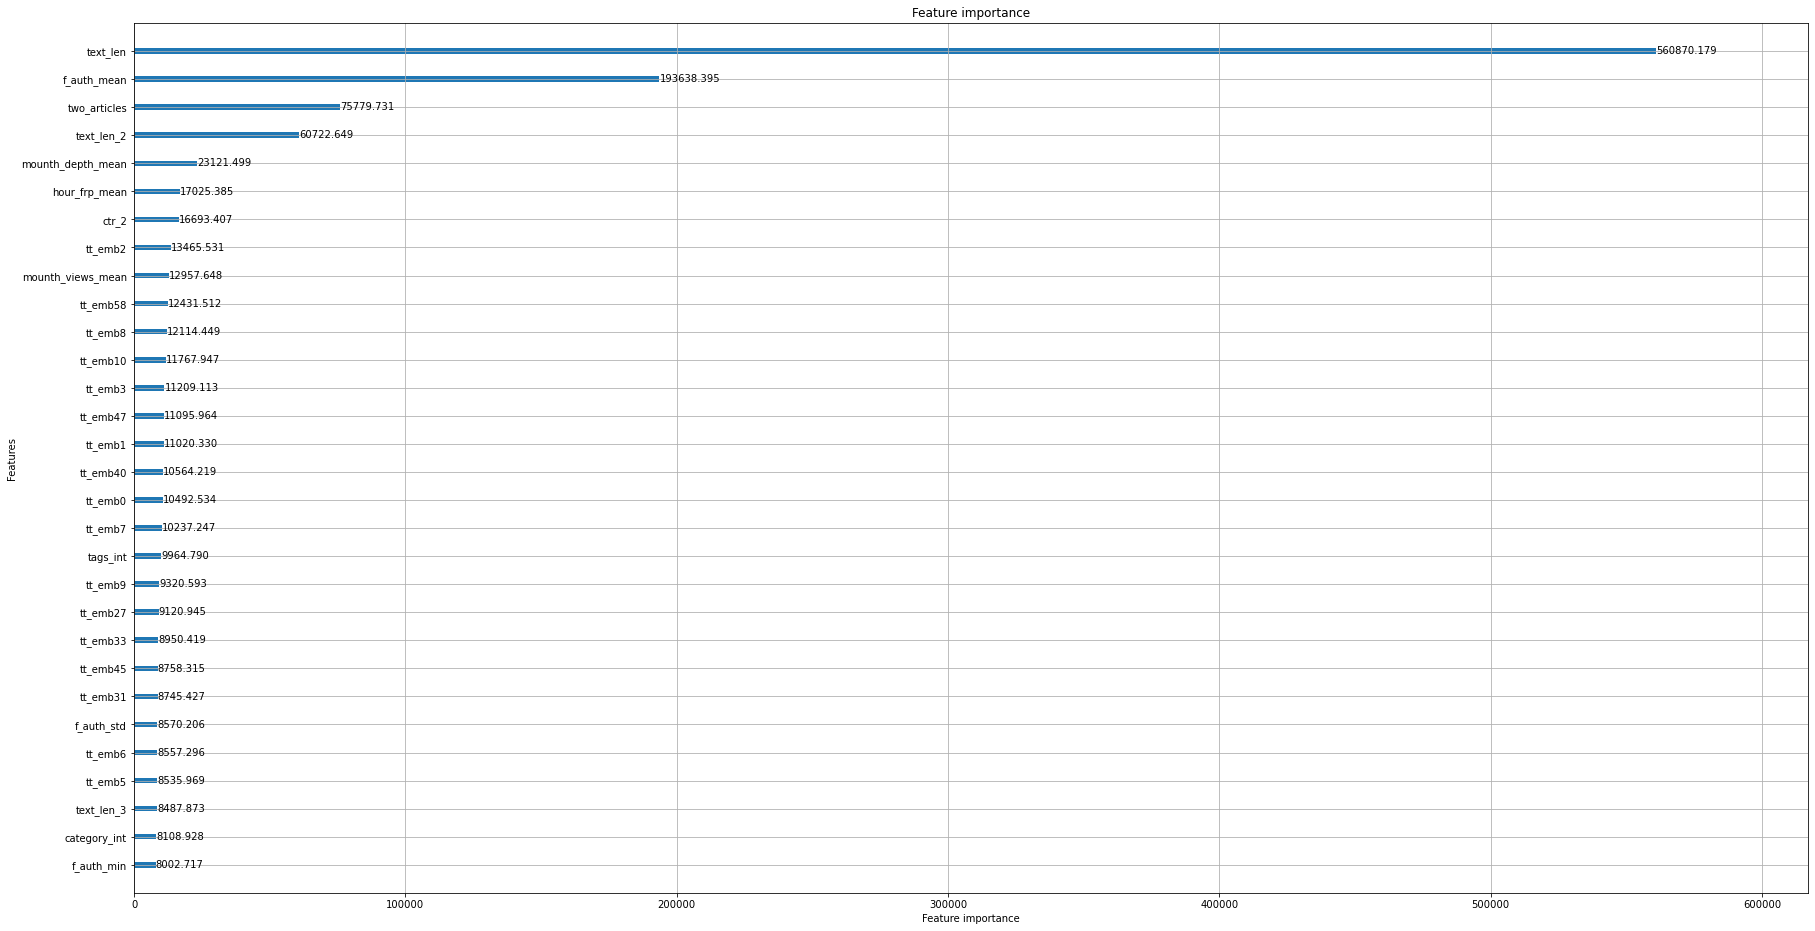

In [42]:
lgb.plot_importance(lgb_model_frp_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

# Сохраняем предсказания для ансамблей / стекинга

## save models

In [43]:
lgb_model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_start.txt'), num_iteration = lgb_model_views_start.best_iteration)
lgb_model_views_end.save_model(  os.path.join(DIR_MODELS, f'{NAME}_v_end.txt'),   num_iteration = lgb_model_views_end.best_iteration)
lgb_model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_start.txt'), num_iteration = lgb_model_depth_start.best_iteration)
lgb_model_depth_end.save_model(  os.path.join(DIR_MODELS, f'{NAME}_d_end.txt'),   num_iteration = lgb_model_depth_end.best_iteration)
lgb_model_frp_start.save_model(  os.path.join(DIR_MODELS, f'{NAME}_f_start.txt'), num_iteration = lgb_model_frp_start.best_iteration)
lgb_model_frp_end.save_model(    os.path.join(DIR_MODELS, f'{NAME}_f_end.txt'),   num_iteration = lgb_model_frp_end.best_iteration)

## Делаем предсказание трейна для ансамблей

In [61]:
pred_train = pd.DataFrame()
pred_train[['document_id', 'distrib_brdr']] = df_train[['document_id', 'distrib_brdr']]
pred_train = pred_train.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [62]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'views'] = lgb_model_views_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'views'] = lgb_model_views_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
print(sum(pred_train.views.isna()), ' Nan in views')

0  Nan in views


In [63]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'depth'] = lgb_model_depth_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'depth'] = lgb_model_depth_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
print(sum(pred_train.depth.isna()), ' Nan in depth')

0  Nan in depth


In [64]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'full_reads_percent'] = lgb_model_frp_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'full_reads_percent'] = lgb_model_frp_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
print(sum(pred_train.full_reads_percent.isna()), ' Nan in full_reads_percent')

0  Nan in full_reads_percent


In [65]:
pred_train.drop(['distrib_brdr'], axis =1, inplace = True)
pred_train.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)

# Делаем предсказание для теста

In [66]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = df_test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [67]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = lgb_model_views_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = lgb_model_views_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.views.isna())

0

In [68]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = lgb_model_depth_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = lgb_model_depth_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.depth.isna())

0

In [69]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = lgb_model_frp_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = lgb_model_frp_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.full_reads_percent.isna())

0

In [70]:
subm.drop(['distrib_brdr'], axis = 1, inplace = True)

In [71]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,147495.556164,1.167330,24.851293
1440,131815.738502,1.181221,24.864843
2645,150610.166375,1.190561,26.608549


In [72]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [73]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,12910.305052,1.222185,43.463925
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,5325.436216,1.061219,33.698672
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,7428.327023,1.064351,30.054076
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,4453.210839,1.063778,39.488574
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,106031.995660,1.144884,27.975068


In [74]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)

In [75]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 13.92 Minutes
